## Det(AI)ls team work for Data Visualization and Text Mining project


F. M. 5______

M. G. V. 5______

S. M. 5______

# **Italian NLP corpus**

Our text corpus contains two different datasets: one made of 1123 Italian sentences and and another made of 1200 English sentences, which are rated by humans with a judgment of complexity. Judgments have been collected through a crowdsourcing task in which 20 native speakers of each language have been asked to judge how difficult they perceived a given sentence on a complexity scale from 1 (i.e. “very easy”) to 7 (i.e. “very difficult”).

The datasets of sentences have been taken from two different manually revised treebanks: the newspaper section of the Italian Universal Dependency Treebank (IUDT) for the Italian experiment, and the automatically converted Wall Street Journal section of the Penn Treebank for the English experiment.

We start taking into consideration the English dataset for our classification project, in which we try to build a model able to predict for each sentence the corresponding complexity judgement.

## **Data Exploratory Analysis**


### Importing libraries and the dataset

In [ ]:
# Importing all the necessary libraries
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import relu
import numpy as np  
import pandas as pd 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import spacy
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.subplots
import plotly.colors
import plotly.graph_objects as go
import sklearn
!pip install gitpython
import git
from git import Repo
import os
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
import re
import urllib
import sklearn
import logging
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the dataset from github

url = 'https://media.githubusercontent.com/media/nluninja/nlp_datasets/main/italiannlp/data/complexity_ds_en.csv'

In [ ]:
# Reading the dataset

dataset = pd.read_csv(url)

### Data cleaning

We start preparing and cleaning our data, by checking in particualar for duplicated sentences, which may affect the analysis.

In [ ]:
# Looking for duplicated sentences
# Returning boolean series to denote duplicate rows; in particular it marks all duplicates as 'True', if setted to False. 

dupl_bool = dataset['SENTENCE'].duplicated(keep = False)

In [ ]:
# Looping through the series in order to show the row position of each duplicated sentence.

idx = []
for i in range(dupl_bool.shape[0]):
  if dupl_bool[i]:
    idx.append(i)

In [ ]:
all_dupl = dataset.iloc[idx, :] # Considering all the duplicates
all_dupl.sort_values(by = ['SENTENCE']) # Sorting the duplicated sentences in alphabetic order

,ID,SENTENCE,judgement1,judgement2,judgement3,judgement4,judgement5,judgement6,judgement7,judgement8,...,judgement11,judgement12,judgement13,judgement14,judgement15,judgement16,judgement17,judgement18,judgement19,judgement20
1060,951587119,CALL MONEY: 9 3/4 % to 10 %.,5,5,6,6,2,1,1,3,...,6,1,4,3,5,7,4,6,7,1
1055,951587036,CALL MONEY: 9 3/4 % to 10 %.,7,2,1,1,4,7,1,4,...,2,7,1,1,3,3,4,1,4,2
720,951587037,CALL MONEY: 9 3/4 % to 10 %.,7,1,1,2,2,2,4,1,...,2,7,1,1,1,3,5,5,3,1
663,951587035,CALL MONEY: 9 3/4 % to 10 %.,4,1,4,1,4,1,6,2,...,4,4,5,5,3,2,7,4,3,4
22,951587067,Source: Fulton Prebon (U.S.A.) Inc.,3,1,1,1,1,2,3,5,...,1,1,3,6,4,1,2,2,1,5
987,951587070,Source: Fulton Prebon (U.S.A.) Inc.,4,1,1,1,2,4,4,1,...,1,6,1,1,3,1,1,1,1,1
858,951587063,Source: Fulton Prebon (U.S.A.) Inc.,5,2,1,1,1,2,1,2,...,1,1,2,2,3,1,3,1,3,2
1070,951587069,Source: Fulton Prebon (U.S.A.) Inc.,4,1,1,1,1,1,3,1,...,1,1,1,2,1,6,3,1,1,5
697,951587066,Source: Fulton Prebon (U.S.A.) Inc.,3,1,1,1,2,3,4,1,...,1,6,2,2,1,3,1,1,1,2
614,951587145,Source: Fulton Prebon (U.S.A.) Inc.,3,2,1,1,1,1,1,1,...,1,2,6,1,1,1,1,2,1,2


In [ ]:
dupl_bool_2 = dataset['SENTENCE'].duplicated(keep = 'first') # Not considering the first occurrance as duplicate for each set of sentences
sum(dupl_bool) - sum(dupl_bool_2) # Finding the number of sentences which have duplicates

4

We can see that there are 4 sentences which have duplicates; since duplicated sentences have different judgements of complexity whitin the same set, we can't simply delete them but we have to replace their 20 judgements with the mean values for each set, in order to preserve information.

In [ ]:
# Creating a list containing the first occurrance for each duplicated sentence

dupl_sentences = [] 
k = [0]
all_dupl = all_dupl.sort_values(by = ['SENTENCE'])
dupl_sentences.append(all_dupl.iloc[0,1])
for i in range(sum(dupl_bool)-1):
  if all_dupl.iloc[i,1] != all_dupl.iloc[i+1,1]:
    dupl_sentences.append(all_dupl.iloc[i+1,1])
    k.append(i)

In [ ]:
dupl_sentences

['CALL MONEY: 9 3/4 % to 10 %.',
 'Source: Fulton Prebon (U.S.A.) Inc.',
 'The record price for a full membership on the exchange is $ 550,000, set Aug. 31, 1987.',
 "UAL declined to comment on British Air's statement."]

In [ ]:
k # Showing the row position at which starts the k-th duplicated sentence

[0, 3, 13, 15]

In [ ]:
idx_2 = []
for i in range(dupl_bool_2.shape[0]):
  if dupl_bool_2[i]:
    idx_2.append(i)

In [ ]:
idx_2  # Showing the row position of the duplicated sentences (not considering first occurances)

[133, 265, 404, 614, 686, 697, 720, 858, 987, 1010, 1055, 1060, 1070, 1150]

In [ ]:
df_div = [] # Creating a list of dataframes

df_div.append(all_dupl.iloc[list(np.arange(k[0],k[1]+1))])
df_div.append(all_dupl.iloc[list(np.arange(k[1]+1,k[2]+1))])
df_div.append(all_dupl.iloc[list(np.arange(k[2]+1,k[3]+1))])
df_div.append(all_dupl.iloc[list(np.arange(k[3]+1,all_dupl.shape[0]))])

In [ ]:
cols_ = np.array(all_dupl.columns)

In [ ]:
# Creating a dataframe for each set of duplicated sentences

Dupl_1 = pd.DataFrame(columns = cols_) 
Dupl_2 = pd.DataFrame(columns = cols_)
Dupl_3 = pd.DataFrame(columns = cols_)
Dupl_4 = pd.DataFrame(columns = cols_)

In [ ]:
# Do the above step for the first set of duplicates

Dupl_1.loc[0,'ID'] = df_div[0].iloc[0,0]
Dupl_1.loc[0,'SENTENCE'] = df_div[0].iloc[0,1]
for i in range(20):
  media_i = round(np.mean(df_div[0].iloc[ : , 2 + i]))
  Dupl_1.iloc[0, 2 + i] = media_i

In [ ]:
# Do it for the second set of duplicates

Dupl_2.loc[0,'ID'] = df_div[1].iloc[0,0]
Dupl_2.loc[0,'SENTENCE'] = df_div[1].iloc[0,1]
for i in range(20):
  media_i = round(np.mean(df_div[1].iloc[ : , 2 + i]))
  Dupl_2.iloc[0, 2 + i] = media_i

In [ ]:
# Do it for the third set of duplicates

Dupl_3.loc[0,'ID'] = df_div[2].iloc[0,0]
Dupl_3.loc[0,'SENTENCE'] = df_div[2].iloc[0,1]

for i in range(20):
  media_i = round(np.mean(df_div[2].iloc[ : , 2 + i]))
  Dupl_3.iloc[0, 2 + i] = media_i

In [ ]:
# Do it for the fourth set of duplicates

Dupl_4.loc[0,'ID'] = df_div[3].iloc[0,0]
Dupl_4.loc[0,'SENTENCE'] = df_div[3].iloc[0,1]
for i in range(20):
  media_i = round(np.mean(df_div[3].iloc[ : , 2 + i]))
  Dupl_4.iloc[0, 2 + i] = media_i

In [ ]:
dataset = dataset.drop_duplicates(subset = 'SENTENCE', keep = False) # Deleting all duplicates

Now we add the first occurrance for each set of duplicates sentences to the dropped-duplicates dataset in order to have the final dataset.

In [ ]:
# Appendng to the dataset the first row of each dataframe created 

dataset = dataset.append(Dupl_1.iloc[0, :])
dataset = dataset.append(Dupl_2.iloc[0, :])
dataset = dataset.append(Dupl_3.iloc[0, :])
dataset = dataset.append(Dupl_4.iloc[0, :])

In [ ]:
dataset = dataset.reset_index(drop = True) # Re-indexing the final dataset

At the end we have to check if there are judgements values over the maximum (7) or under the minimum (1), in order to verify if our procedure up to this point is correct.


In [ ]:
# Looping through dataset rows and judgements columns

for k in range(dataset.shape[0]):
  for i in range(2, 22):
    if dataset.iloc[k, i] > 7 or dataset.iloc[k, i]<1:
      print(k, i)

We have nothing printed as we expected, so we can continue with the Data visualization part.

### Data Visualization

We start having a quick look to our sentences and judgements.

In [ ]:
# Sentences

id = dataset.loc[:, 'ID']; id
sentence = dataset.loc[:, 'SENTENCE']; sentence

0       Amcast Industrial Corp. said it plans to repur...
1       GDP is the total value of a nation's output of...
2       Town & Country Ford in Charlotte, N.C., still ...
3       A couple in Rockford, Ill., raised $ 12,591 ea...
4       Yesterday the company said it had filed a requ...
                              ...                        
1181    Also as usual, the products will appeal mostly...
1182                         CALL MONEY: 9 3/4 % to 10 %.
1183                  Source: Fulton Prebon (U.S.A.) Inc.
1184    The record price for a full membership on the ...
1185    UAL declined to comment on British Air's state...
Name: SENTENCE, Length: 1186, dtype: object

In [ ]:
# Judgements

judg = dataset.iloc[ :, 2:]

We now proceed to compute the mean and the median of the 20 different complexity judgements for each sentence, in order to have an idea of the frequency distributions of our data. 

In [ ]:
# Computing the mean and the median 

l_means = []
l_meds = []
for i in range(judg.shape[0]):
  l_means.append(round(np.mean(judg.iloc[i, :])))
  l_meds.append(round(np.median(judg.iloc[i, :])))

At this point we check if using the mean or the median is almost the same for our analysis, and in how many cases the difference between using one instead of the other is equal or below one.

In [ ]:
# Initializing a count variable and looping through judgements

count = 0
for i in range(judg.shape[0]):
  if l_means[i] == l_meds[i]:
    count += 1
print(f'Mean and Median are the same in {100*round(count/judg.shape[0], 4)}% of cases')

Mean and Median are the same in 73.86% of cases


In [ ]:
# Initializing a count variable and looping through judgements

count = 0
for i in range(judg.shape[0]):
  if abs(l_means[i] - l_meds[i]) <= 1:
    count += 1
print(f'Mean and Median difference is below 1 in {100*round(count/judg.shape[0], 4)} % of cases')

Mean and Median difference is below 1 in 100.0 % of cases


#### Class Frequencies

We start considering the median for judgements of each sentence.

In [ ]:
# Creating a dataframe to consider the median values

df = pd.DataFrame(sentence)
df['Judgement'] = np.array(l_meds)

In [ ]:
print(f'{df.iloc[0,:][0]}', '\n' f'has judgement {df.iloc[0,:][1]}')

Amcast Industrial Corp. said it plans to repurchase 500,000 shares, or about 7 % of its shares outstanding, in open market transactions. 
has judgement 2


After this we check if there are null values or entire missing sentences and judgements.

In [ ]:
# Null values

df.isnull().sum()

SENTENCE     0
Judgement    0
dtype: int64

In [ ]:
# Missing indexes, sentences or judgements

blanck = []
for idx, sent, judg in df.itertuples():
  if type(sent) == str:
    if sent.isspace():
      blanck.append(idx)
blanck

[]

As we can see, there aren't null values or blank sentences.

We then procede to compute absolute and relative frequencies for judgements classes obtained with the median in order to build a bar plot to better visualize them.

In [ ]:
# Absolute and relative frequencies 

abs_val_med = df['Judgement'].value_counts()
rel_val_med = round(df['Judgement'].value_counts(normalize = True), 4)

In [ ]:
abs_val_med.sort_index() , rel_val_med.sort_index()

(1    161
 2    429
 3    338
 4    221
 5     35
 6      2
 Name: Judgement, dtype: int64, 1    0.1358
 2    0.3617
 3    0.2850
 4    0.1863
 5    0.0295
 6    0.0017
 Name: Judgement, dtype: float64)

In [ ]:
# Building the bar plot 

# Importing the Plotly Express
import plotly.express as px
# Define a dataframe to visualize the percentage of relative frequencies
data_med = pd.DataFrame(rel_val_med.sort_index())

data_med.insert(1, "%", [str(round(t * 100, 4))+'%' for t in data_med['Judgement']] , True) #adding the percentage column

In [ ]:
fig = px.bar(data_med, color = [1, 2, 3, 4, 5, 6],
             labels = {
                 'index' : 'Judgement', 'value': 'Percentage (%)'
                 },
             title = 'Complexity Judgement for Median', 
             text = '%'
             )
fig.update(layout_coloraxis_showscale=False)
fig.show()

From the above bar plot we observe that the frquency distribution of sentences obtained with the median is skewed; this suggests an unbalanced classification of complexity judgements. In particular the 2nd complexity class counts the 
36,17% of sentences, while the 6th class only the 0,17%.

We now repeat the above procedure by considering the mean values for judgements, in order to decide which index is better for our classification purpose.

In [ ]:
# Creating a dataframe to consider the mean values

df2 = pd.DataFrame(sentence)
df2['Judgement'] = np.array(l_means)
df.head()

,SENTENCE,Judgement
0,Amcast Industrial Corp. said it plans to repur...,2
1,GDP is the total value of a nation's output of...,1
2,"Town & Country Ford in Charlotte, N.C., still ...",2
3,"A couple in Rockford, Ill., raised $ 12,591 ea...",3
4,Yesterday the company said it had filed a requ...,3


In [ ]:
# Absolute and relative frequencies 

abs_val_mean = df2['Judgement'].value_counts()
rel_val_mean = round(df2['Judgement'].value_counts(normalize = True), 4)

In [ ]:
abs_val_mean.sort_index(), rel_val_mean.sort_index()

(1     72
 2    385
 3    450
 4    251
 5     28
 Name: Judgement, dtype: int64, 1    0.0607
 2    0.3246
 3    0.3794
 4    0.2116
 5    0.0236
 Name: Judgement, dtype: float64)

In [ ]:
# Define a dataframe to visualize the percentage of relative frequencies

data_mean = pd.DataFrame(rel_val_mean.sort_index())

data_mean.insert(1, "%", [str(round(t * 100, 4))+'%' for t in data_mean['Judgement']] , True)

In [ ]:
data_mean

,Judgement,%
1,0.0607,6.07%
2,0.3246,32.46%
3,0.3794,37.94%
4,0.2116,21.16%
5,0.0236,2.36%


In [ ]:
# Building bar plot 

fig = px.bar(data_mean, color = [1, 2, 3, 4, 5],
             labels = {
                 'index' : 'Judgement', 'value': 'Percentage (%)'
                 },
             title = 'Complexity Judgement', 
             text = '%'
             )
fig.update(layout_coloraxis_showscale=False)
fig.show()

From the plot above we can see that using mean as frequency index leads to a more balanced classification of complexity judgements in the middle classes, while the 6th class isn't even represented. 

For this reason we decide to continue with the means as index values for our data.

In [ ]:
# Overwriting the dataset to the one with the means

df = df2

In [ ]:
np.random.seed(22+700)
for j in range(3):
  i = np.random.choice(df.shape[0], size = 1)
  a = list(df.iloc[i, 0])
  b = list(df.iloc[i, 1])
  print(f'SENTENCE: {str(a[0])} JUDGEMENT: {b[0]}')

SENTENCE: If the deal closes, the two officers will draw salaries from the independent operation, not from Integrated. JUDGEMENT: 2
SENTENCE: Jack Davis, Dataproducts' chairman, said he hadn't yet seen the filing and couldn't comment. JUDGEMENT: 2
SENTENCE: Auto shares were mixed, as Daimler-Benz firmed 2 to 723, Bayerische Motoren Werke lost the same amount to 554, and Volkswagen inched down 1.4 to 451.6. JUDGEMENT: 4


#### Length of the sequence

After Data preparation & Data cleaning, we are going to compute the length, i.e.number of characters, and the number of tokens (both with and without stopwords) for each sentence, in order to underline possible correlations with the corresponding complexity class. We do this with the help of bar plots, histograms and box plots.

At the beginning we keep the stopwords

In [ ]:
# Computing the length of each sentence 

str_len = [len(i.replace(" ", "")) for i in df.iloc[:,0]]
df['length'] = pd.Series(str_len)

In [ ]:
df.head()

,SENTENCE,Judgement,length
0,Amcast Industrial Corp. said it plans to repur...,3,115
1,GDP is the total value of a nation's output of...,2,54
2,"Town & Country Ford in Charlotte, N.C., still ...",2,75
3,"A couple in Rockford, Ill., raised $ 12,591 ea...",3,129
4,Yesterday the company said it had filed a requ...,3,138


In [ ]:
fig = px.violin(df, y = "length", x = "Judgement", color = "Judgement", 
                box = True, points = 'all', title ='Violin of Judgement vs Length')
fig.layout.update(showlegend = False) 
fig.show()

From the plot above we see that more complex sentences are composed by a larger number of characters.

#### Number of tokens

In [ ]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 16 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# Starting the Tokenization
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Computing the number of tokens for each sentence
tokeniz_ = []
for k in range(df.shape[0]):
  tokeniz_.append(len(nlp(df.loc[k,'SENTENCE'])))

In [ ]:
df['N° Tokens'] = np.array(tokeniz_)

In [ ]:
df.head()

,SENTENCE,Judgement,length,N° Tokens
0,Amcast Industrial Corp. said it plans to repur...,3,115,25
1,GDP is the total value of a nation's output of...,2,54,15
2,"Town & Country Ford in Charlotte, N.C., still ...",2,75,20
3,"A couple in Rockford, Ill., raised $ 12,591 ea...",3,129,30
4,Yesterday the company said it had filed a requ...,3,138,25


In [ ]:
fig = px.violin(df, y = "N° Tokens", x = "Judgement", color = "Judgement", 
                box = True, points = 'all', title ='N°Tokens vs Judgement of complexity <br><sup> considering the tokeninzation with StopWords</sup>')
fig.update_layout(autosize = True)
fig.layout.update(showlegend = False)
fig.show()

From the plot above we see that more complex sentences are composed by a larger number of tokens.

#### Tokenizing with stop words

In [ ]:
# Tokenization with stop words
tokeniz_2 = []
for k in range(df.shape[0]):
  toks = nlp(df.loc[k,'SENTENCE'])
  count_stop = 0
  tot_toks = len(toks)
  for i in toks:
    if nlp.vocab[str(i)].is_stop:
      count_stop += 1
  tot_toks =tot_toks - count_stop
  tokeniz_2.append(tot_toks)

In [ ]:
df['Tokens_Stop_Words'] = np.array(tokeniz_2)

In [ ]:
df.head()

,SENTENCE,Judgement,length,N° Tokens,Tokens_Stop_Words
0,Amcast Industrial Corp. said it plans to repur...,3,115,25,18
1,GDP is the total value of a nation's output of...,2,54,15,8
2,"Town & Country Ford in Charlotte, N.C., still ...",2,75,20,14
3,"A couple in Rockford, Ill., raised $ 12,591 ea...",3,129,30,18
4,Yesterday the company said it had filed a requ...,3,138,25,14


In [ ]:
fig = px.violin(df, y = "Tokens_Stop_Words", x = "Judgement", color = "Judgement", 
                box = True,points = 'all', title ='N°Tokens vs Judgement of complexity <br><sup> considering the tokeninzation without StopWords</sup>')
fig.update_layout(autosize = True)
fig.layout.update(showlegend = False)
fig.show()

We can clearly see from the pictures that the complexity judgements of sentences increase as the length or the number of tokens increase, except very few outliers.

In [ ]:
df.head()

,SENTENCE,Judgement,length,N° Tokens,Tokens_Stop_Words
0,Amcast Industrial Corp. said it plans to repur...,3,115,25,18
1,GDP is the total value of a nation's output of...,2,54,15,8
2,"Town & Country Ford in Charlotte, N.C., still ...",2,75,20,14
3,"A couple in Rockford, Ill., raised $ 12,591 ea...",3,129,30,18
4,Yesterday the company said it had filed a requ...,3,138,25,14


In [ ]:
graph = pd.DataFrame()

count, bin_edges = np.histogram(df['N° Tokens'], bins = 33)

graph['N°Tokens'] = [x+8 for x in range(33)]
graph['Frequencies'] = count

In [ ]:
fig = px.bar(graph, x = 'N°Tokens', y = 'Frequencies', title = 'N°Tokens in a Sentence <br><sup> considering the sentence with StopWords</sup>')
fig.update_traces(marker_color = 'blue')
fig.layout.update(showlegend = False) 

fig.show()

Here we can see a particular pattern which suggests that the majority of sentences has a number of tokens multiple of 5 tokens.

In [ ]:
count_nostop, bin_edges = np.histogram(df['Tokens_Stop_Words'] ,bins = 28)

graph_nostop = pd.DataFrame()

graph_nostop['N°Tokens'] = [x for x in range(28)]
graph_nostop['Frequencies'] = count_nostop

In [ ]:
fig = px.bar(graph_nostop, x = 'N°Tokens', y = 'Frequencies', title = 'N°Tokens in a Sentence <br><sup> considering the sentence without StopWords</sup>')
fig.update_traces(marker_color = 'blue')
fig.layout.update(showlegend = False) 
fig.show()

Proceeding with the analysis we removed the stop words from the sentences, in order to see if the pattern would have repeated or not; the result is that the main distribution of Tokens is between 5 and 15.

#### Word Clouds

Now we continue with some examples of word clouds, in order to have a visual representantion of words which appear more frequently both in the whole dataset and in each complexity class. 

In [ ]:
df_string = ""
for k in range(df.shape[0]):
  df_string = df_string + " " + df['SENTENCE'][k]

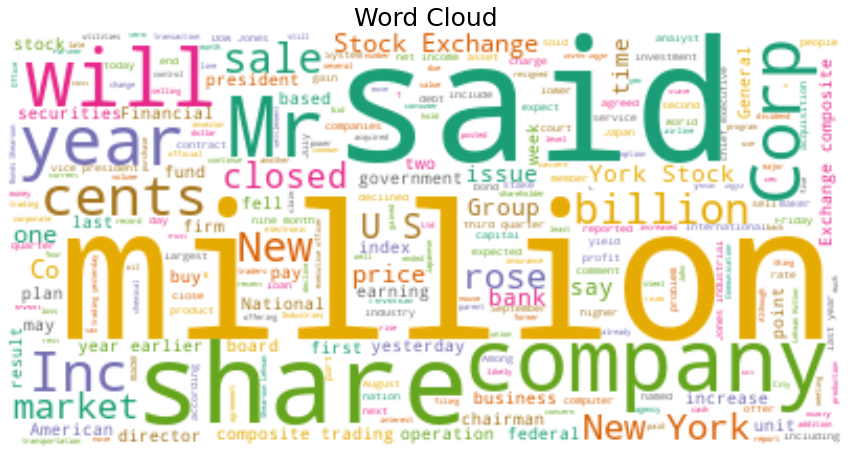

In [ ]:
stopwords = set(STOPWORDS)
df_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords,
    colormap="Dark2")

# Generate the word cloud for the whole dataset

df_wc.generate(df_string)
plt.figure(figsize=(15, 15))
plt.imshow(df_wc, interpolation='bilinear')
plt.title('Word Cloud', fontsize = 25)
plt.axis('off')
plt.show()

In [ ]:
# constructing the list for each Judgement in the dataset

df_1_string = ""
df_2_string = ""
df_3_string = ""
df_4_string = ""
df_5_string = ""
for k in range(df.shape[0]):
  if df['Judgement'][k] == 1:
    df_1_string = df_1_string + " " + df['SENTENCE'][k]
  elif df['Judgement'][k] == 2:
    df_2_string = df_2_string + " " + df['SENTENCE'][k]
  elif df['Judgement'][k] == 3:
    df_3_string = df_3_string + " " + df['SENTENCE'][k]
  elif df['Judgement'][k] == 4:
    df_4_string = df_4_string + " " + df['SENTENCE'][k]
  elif df['Judgement'][k] == 5:
    df_5_string = df_5_string + " " + df['SENTENCE'][k]

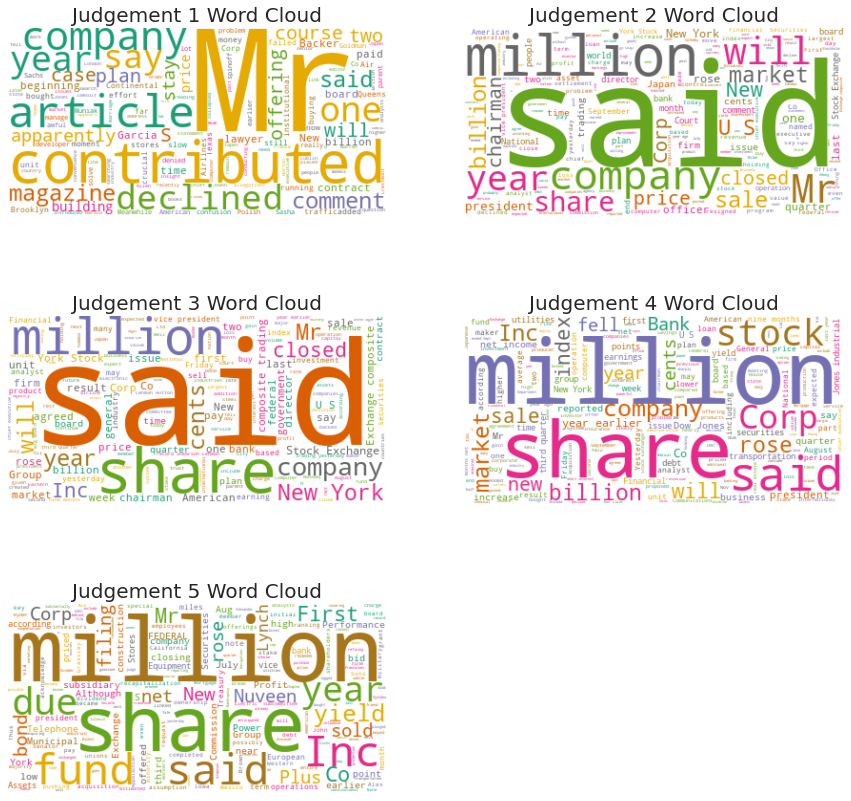

In [ ]:
import seaborn as sns
from wordcloud import WordCloud
sns.set()
plt.rcParams['figure.figsize'] = [15, 15]

topics_list = [df_1_string, df_2_string, df_3_string, df_4_string, df_5_string]

wordcloud = WordCloud(background_color="white", 
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2")

# represent each Judgement class in a WordCloud
for i in range(5):
    wordcloud.generate(text=topics_list[i])   
    plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    fontsize = 20
    plt.title(f'Judgement {i+1} Word Cloud', fontdict={'fontsize': fontsize})

plt.show()

We can see that the same words appear regardless of the complexity class. 

Since the words 'said'/'say' seem to be redundant and without a particular meaning, we consider them as Stopwords.

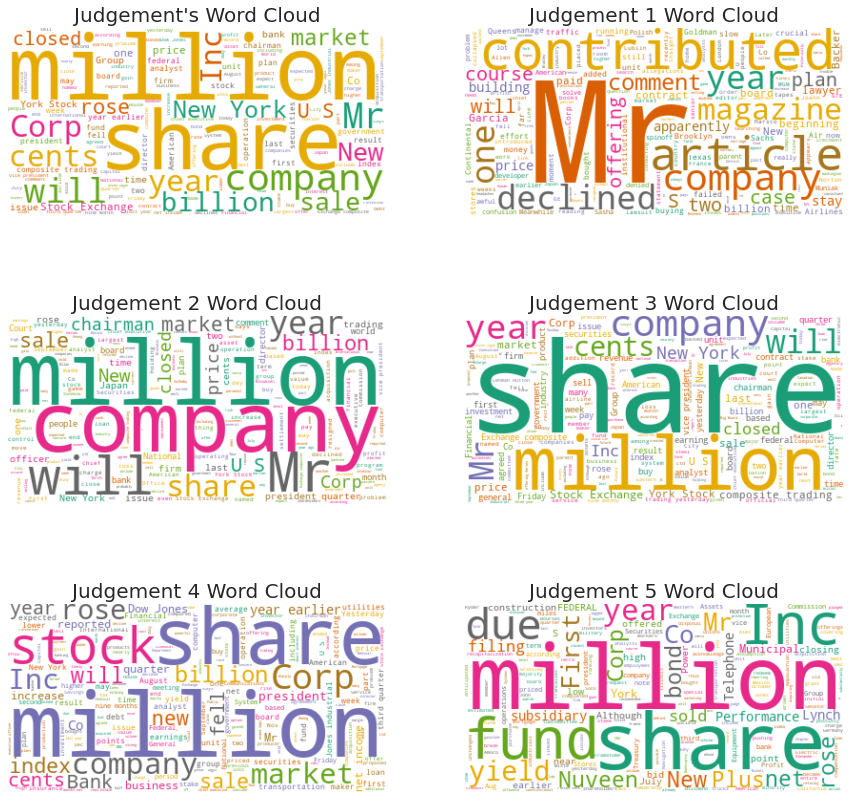

In [ ]:
# add the most frequent StopWords we saw above in the StopWords class
stopwords.add('said')
stopwords.add('say')
df_wc.generate(df_string)

sns.set()
plt.rcParams['figure.figsize'] = [15, 15]

topics_list = [df_1_string, df_2_string, df_3_string, df_4_string, df_5_string]

topics_list.insert(0, df_string)

wordcloud = WordCloud(background_color="white", 
                      contour_color="black",  max_font_size=150, random_state=42,
                      colormap="Dark2", stopwords = stopwords)

# Generate again the WordCloud to see the difference from above
for i in range(6):
    wordcloud.generate(text=topics_list[i])   
    plt.subplot(3, 2, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    fontsize = 20
    if i == 0:
      plt.title('Judgement\'s Word Cloud', fontdict={'fontsize': fontsize})  
    else:
      plt.title(f'Judgement {i} Word Cloud', fontdict={'fontsize': fontsize})

plt.show()

By removing the more frequent StopWords ('said' and 'say') we don't see a consistent changing. 

We can state from the result that the main dataset is about financial themes.

## **RECURRENT NEURAL NETWORK**

We can now start implementing the RNN and trying different LSTM models.

In [ ]:
# Importing functions from 'utils' folder from github

try:
  Repo.clone_from("https://github.com/mf/NLP_Text_Mining.git", "./utils")
except:
  print('Directory already existing')

In [ ]:
%pwd

'/content'

In [ ]:
%cd utils

/content/utils


Now we create a folder in the environment to store the model for later purposes.

In [ ]:
try:
  path = os.path.join('./model')
  os.mkdir(path)
except:
  print('Directory already exist')

In the next 2 chunks we manage the import of the functions present in the util folder downloaded.

In [ ]:
import os
os.rename('./utils', './utils_1')

In [ ]:
from utils_1 import dataio, kerasutils, modelutils

### Deleting stop words

Firstly we implement our RNN model not considering StopWords.

In [ ]:
data = df.copy()
data['SENTENCE'] = data['SENTENCE'].apply(lambda x: x.lower()) # transforming sentences in lowercase
data['Judgement'] = data['Judgement'].apply(lambda x: str(x)) # transforming judgements in strings

In [ ]:
for k in range(data.shape[0]):
  toks = nlp(data.loc[k,'SENTENCE'])
  new_sentence = ""
  tot_toks = len(toks)
  for i in toks:
    if nlp.vocab[str(i)].is_stop:
      new_sentence = new_sentence + ' ' + str(i)
  data.loc[k,'SENTENCE'] = new_sentence

In [ ]:
# tokenization of the senteces

max_features = 10000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(data['SENTENCE'].values)
X = tokenizer.texts_to_sequences(data['SENTENCE'].values)

In [ ]:
sequence_len = np.array([len(s) for s in X])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

# visualizing the percentile of the sentences length
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 21
[('75%', 11.0), ('80%', 11.0), ('85%', 12.0), ('90%', 14.0), ('95%', 15.0), ('100%', 21.0)]


In [ ]:
# padding to uniform sentences length to the longest one (21)
X = pad_sequences(X)

In [ ]:
# tranform the Judgement value in a dummy variable
Y = pd.get_dummies(data['Judgement']).values
# divide in train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(830, 21)
(356, 21)


In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
%cd ..

/content


In [ ]:
%cd ./utils/model

/content/utils/model


In [ ]:
# stop condition for the model
early_stopping_callback = EarlyStopping(monitor="loss", min_delta = 0.01, patience=3, verbose=1, mode="auto", restore_best_weights=True)
# crate a directory to save the checkpoint without reloading it everytime
best_model_file = os.path.join('./','model_5.h5')
checkpoint = ModelCheckpoint( best_model_file,
    save_weights_only = True,
    save_best_only = True)

Here we define the function to implement K-fold Cross Validation which allows us to tune different models.

In [ ]:
import tensorflow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

batch_size = 128

# definition of K-Fold CrossValidation function

def K_fold_cross_validation(model_train, X_train, Y_train, num_fold = 5,
                            loss_function = 'categorical_crossentropy', optimizer = 'adam', batch_size = batch_size,
                            no_epochs = 10, verbosity= 2, early_stopping_callback = early_stopping_callback):
    # Merge inputs and targets
    inputs = X_train
    targets = Y_train

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_fold, shuffle=True,random_state=42)
    acc_per_fold = []
    loss_per_fold = []
    # K-fold Cross Validation model evaluation
    fold_no = 1
    weights_init = model_train.get_weights() 
    for train, test in kfold.split(inputs, targets):
      model = model_train

      model.set_weights(weights_init)

      # Compile the model
      model.compile(loss=loss_function,
                    optimizer=optimizer,
                    metrics=['accuracy'])

      # Generate a print
      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_no} ...')

      # Fit data to model
      history = model.fit(inputs[train], targets[train],
                  batch_size=batch_size,
                  epochs=no_epochs,
                  verbose=verbosity,
                  callbacks = early_stopping_callback)

      # Generate generalization metrics
      scores = model.evaluate(inputs[test], targets[test], verbose=0)
      print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])
      # Increase fold number
      fold_no = fold_no + 1
    print(f'Mean of accuracy in each fold: {round(np.mean(np.array(acc_per_fold)),4)}%')

Now we are going to implement an LSTM model using Keras Embedding, an LSTM hidden layer, with a dropout equal to 20%, and a Dense layer to obtain our output of 5 classes through a Softmax activation function.

#### LSTM without StopWords

In [ ]:
# Implementing 1st LSTM model

embed_dim = 256
lstm_out = 196

model = Sequential()
# Embedding
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# LSTM
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# linear NN
model.add(Dense(5, activation='softmax'))

K_fold_cross_validation(model_train = model, X_train = X_train, Y_train = Y_train, no_epochs = 5) 

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 3s - loss: 1.5612 - accuracy: 0.4202 - 3s/epoch - 580ms/step
Epoch 2/5
6/6 - 1s - loss: 1.2658 - accuracy: 0.4443 - 1s/epoch - 176ms/step
Epoch 3/5
6/6 - 1s - loss: 1.0655 - accuracy: 0.5648 - 1s/epoch - 180ms/step
Epoch 4/5
6/6 - 1s - loss: 0.9330 - accuracy: 0.6054 - 999ms/epoch - 166ms/step
Epoch 5/5
6/6 - 1s - loss: 0.8249 - accuracy: 0.6627 - 1s/epoch - 192ms/step
Score for fold 1: loss of 1.0351123809814453; accuracy of 54.81927990913391%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 3s - loss: 1.5645 - accuracy: 0.4548 - 3s/epoch - 565ms/step
Epoch 2/5
6/6 - 1s - loss: 1.2847 - accuracy: 0.4443 - 1s/epoch - 175ms/step
Epoch 3/5
6/6 - 1s - loss: 1.0943 - accuracy: 0.5377 - 1s/epoch - 177ms/step
Epoch 4/5
6/6 - 1s - loss: 0.9137 - accuracy: 0.6009 - 1s/epoch - 168ms/step
Epoch 5/5
6/6 - 1s - loss: 0.8248

Thanks to the K-fold we obtain a mean of the validation accuracy of around 58% for the five folds defined. Now let's see if keeping the stopwords in our dataset is better or not.

### Keeping Stop Words

In order to improve our accuracy we decide to consider Stopwords, since deleting them may return poor sentences and information loss. In this way the model could better fit the data.

In [ ]:
data = df.copy()
data['SENTENCE'] = data['SENTENCE'].apply(lambda x: x.lower())
data['Judgement'] = data['Judgement'].apply(lambda x: str(x))

# tokenization of the senteces
max_features = 10000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(data['SENTENCE'].values)

X = tokenizer.texts_to_sequences(data['SENTENCE'].values)

In [ ]:
sequence_len = np.array([len(s) for s in X])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')
# visualizing the percentile of te sentences length
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 39
[('75%', 26.0), ('80%', 28.0), ('85%', 29.0), ('90%', 31.0), ('95%', 32.0), ('100%', 39.0)]


In [ ]:
X = pad_sequences(X)

In [ ]:
# tranform the Judgement value in a dummy variable
Y = pd.get_dummies(data['Judgement']).values
# divide in train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

(830, 39)
(356, 39)
(830, 5)


#### LSTM layers

We are going to implement again an LSTM model using Keras Embedding, an LSTM hidden layer with an internal and recurrent dropout equal to 20%, and a Dense layer to obtain our output of 5 classes through a Softmax activation function.

In [ ]:
# 1st LSTM model with stopwords

embed_dim = 256
lstm_out = 196

model = Sequential()
# Embedding
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# LSTM
model.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
# linear NN
model.add(Dense(5, activation = 'softmax'))

K_fold_cross_validation(model_train = model, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 3s - loss: 1.5664 - accuracy: 0.3946 - 3s/epoch - 574ms/step
Epoch 2/5
6/6 - 1s - loss: 1.3118 - accuracy: 0.3765 - 1s/epoch - 172ms/step
Epoch 3/5
6/6 - 1s - loss: 1.1753 - accuracy: 0.4910 - 1s/epoch - 176ms/step
Epoch 4/5
6/6 - 1s - loss: 0.9479 - accuracy: 0.5904 - 1s/epoch - 182ms/step
Epoch 5/5
6/6 - 1s - loss: 0.7790 - accuracy: 0.6883 - 1s/epoch - 188ms/step
Score for fold 1: loss of 1.0076286792755127; accuracy of 54.81927990913391%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 5s - loss: 1.5690 - accuracy: 0.3584 - 5s/epoch - 847ms/step
Epoch 2/5
6/6 - 1s - loss: 1.2695 - accuracy: 0.4187 - 1s/epoch - 197ms/step
Epoch 3/5
6/6 - 1s - loss: 1.0426 - accuracy: 0.5678 - 1s/epoch - 189ms/step
Epoch 4/5
6/6 - 1s - loss: 0.9038 - accuracy: 0.6355 - 1s/epoch - 174ms/step
Epoch 5/5
6/6 - 1s - loss: 0.8067 - 

We obtained a mean accuracy of around 60%, which is a quite good result considering our unbalanced classes.

From now on we try different models always considering Stopwords.

At this point we continue adding another LSTM hidden layer and increasing the dropout probability to 50%, in order to see if implementing a more complex and structured model leads to an accuracy improvement.

In [ ]:
# 2nd LSTM model 

embed_dim = 256
lstm_out = 196

model = Sequential()
# Embedding
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# LSTM layer
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4, return_sequences = True))
# LSTM layer
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4))
# Linear NN
model.add(Dense(5, activation='softmax'))

K_fold_cross_validation(model_train = model, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 7s - loss: 1.4882 - accuracy: 0.3193 - 7s/epoch - 1s/step
Epoch 2/5
6/6 - 2s - loss: 1.1875 - accuracy: 0.5407 - 2s/epoch - 342ms/step
Epoch 3/5
6/6 - 2s - loss: 0.9991 - accuracy: 0.6114 - 2s/epoch - 352ms/step
Epoch 4/5
6/6 - 2s - loss: 0.8533 - accuracy: 0.6657 - 2s/epoch - 361ms/step
Epoch 5/5
6/6 - 2s - loss: 0.7481 - accuracy: 0.7289 - 2s/epoch - 374ms/step
Score for fold 1: loss of 1.0604482889175415; accuracy of 56.02409839630127%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 8s - loss: 1.5077 - accuracy: 0.3464 - 8s/epoch - 1s/step
Epoch 2/5
6/6 - 2s - loss: 1.1994 - accuracy: 0.5030 - 2s/epoch - 344ms/step
Epoch 3/5
6/6 - 2s - loss: 0.9585 - accuracy: 0.6099 - 2s/epoch - 340ms/step
Epoch 4/5
6/6 - 2s - loss: 0.8998 - accuracy: 0.6205 - 2s/epoch - 362ms/step
Epoch 5/5
6/6 - 2s - loss: 0.8278 - accura

Having increased the number of LSTM and tried to avoid the overfitting with the Dropout layer we obtain a slight increase in our validation accuracy.

Now we try to model our dataset with Bi-LSTM layers.

#### Bi-LSTM model

We tried with two Bidirectional LSTM layers with a Dropout of 50%, to see if it would have lead and improvement.

Bidirectional long-short term memory (Bidirectional LSTM) is the process of making any neural network to have the sequence information in both directions, backwards (future to past) or forward (past to future).

In [ ]:
# Bi-LSTM model

embed_dim = 256
lstm_out = 196

model = Sequential()
# Embedding
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# Bi-LSTM hidden layer
model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, 
                                 dropout = 0.5))) 
# Bi-LSTM hidden layer 
model.add(Bidirectional(LSTM(lstm_out, return_sequences=False, 
                                 dropout = 0.5)))
# Linear NN
model.add(Dense(5, activation='softmax'))

K_fold_cross_validation(model_train = model, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 6s - loss: 1.4198 - accuracy: 0.4157 - 6s/epoch - 956ms/step
Epoch 2/5
6/6 - 0s - loss: 1.3671 - accuracy: 0.3931 - 161ms/epoch - 27ms/step
Epoch 3/5
6/6 - 0s - loss: 1.0202 - accuracy: 0.5723 - 163ms/epoch - 27ms/step
Epoch 4/5
6/6 - 0s - loss: 0.9028 - accuracy: 0.6190 - 162ms/epoch - 27ms/step
Epoch 5/5
6/6 - 0s - loss: 0.7573 - accuracy: 0.7003 - 159ms/epoch - 26ms/step
Score for fold 1: loss of 1.0740509033203125; accuracy of 53.012049198150635%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 6s - loss: 1.4441 - accuracy: 0.3554 - 6s/epoch - 958ms/step
Epoch 2/5
6/6 - 0s - loss: 1.2337 - accuracy: 0.4262 - 182ms/epoch - 30ms/step
Epoch 3/5
6/6 - 0s - loss: 0.9893 - accuracy: 0.5557 - 161ms/epoch - 27ms/step
Epoch 4/5
6/6 - 0s - loss: 0.8743 - accuracy: 0.6340 - 164ms/epoch - 27ms/step
Epoch 5/5
6/6 - 0s - 

With the use of Bidirectional LSTM we can see an increase in the accuracy to the one of the previous model composed of 2 LSTM layers.

Now let's try to make simpler the Bi-LSTM by considering only one Bi-LSTM layer with a dropout of 50%.

In [ ]:
# Bi-LSTM model

embed_dim = 256
lstm_out = 196

model = Sequential()
# Embedding
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# Bi-LSTM hidden layer
model.add(Bidirectional(LSTM(lstm_out,
                                 dropout = 0.5)))
# Linear NN
model.add(Dense(5, activation='softmax'))

K_fold_cross_validation(model_train = model, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 4s - loss: 1.4908 - accuracy: 0.3765 - 4s/epoch - 734ms/step
Epoch 2/5
6/6 - 0s - loss: 1.2253 - accuracy: 0.4473 - 117ms/epoch - 19ms/step
Epoch 3/5
6/6 - 0s - loss: 1.1909 - accuracy: 0.4593 - 107ms/epoch - 18ms/step
Epoch 4/5
6/6 - 0s - loss: 1.0020 - accuracy: 0.5858 - 87ms/epoch - 15ms/step
Epoch 5/5
6/6 - 0s - loss: 0.8176 - accuracy: 0.6807 - 85ms/epoch - 14ms/step
Score for fold 1: loss of 1.1349024772644043; accuracy of 54.21686768531799%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 3s - loss: 1.5073 - accuracy: 0.2997 - 3s/epoch - 536ms/step
Epoch 2/5
6/6 - 0s - loss: 1.2311 - accuracy: 0.4819 - 118ms/epoch - 20ms/step
Epoch 3/5
6/6 - 0s - loss: 1.0912 - accuracy: 0.5196 - 97ms/epoch - 16ms/step
Epoch 4/5
6/6 - 0s - loss: 0.9852 - accuracy: 0.6340 - 91ms/epoch - 15ms/step
Epoch 5/5
6/6 - 0s - loss:

Simplifying the previous model did not succed in improving the validation accuracy.

To try another model, we used a BatchNormalization layer with the built-in function in keras; this layer applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [ ]:
embed_dim = 256
lstm_out = 196

model = Sequential()
# Embedding
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# LSTM
model.add(LSTM(lstm_out, activation = 'relu', return_sequences = True, dropout = 0.5, recurrent_dropout = 0.2))
model.add(LSTM(lstm_out, activation = 'relu', return_sequences = False, dropout = 0.5, recurrent_dropout = 0.2))
model.add(BatchNormalization())
# linear NN
model.add(Dense(5, activation = 'softmax'))

K_fold_cross_validation(model_train = model, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 8s - loss: 1.4902 - accuracy: 0.3675 - 8s/epoch - 1s/step
Epoch 2/5
6/6 - 2s - loss: 1.2033 - accuracy: 0.5587 - 2s/epoch - 350ms/step
Epoch 3/5
6/6 - 3s - loss: 0.9648 - accuracy: 0.6687 - 3s/epoch - 485ms/step
Epoch 4/5
6/6 - 3s - loss: 0.7114 - accuracy: 0.7620 - 3s/epoch - 535ms/step
Epoch 5/5
6/6 - 3s - loss: 0.4779 - accuracy: 0.8253 - 3s/epoch - 537ms/step
Score for fold 1: loss of 1.435243844985962; accuracy of 33.13252925872803%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 9s - loss: 1.4823 - accuracy: 0.3268 - 9s/epoch - 1s/step
Epoch 2/5
6/6 - 2s - loss: 1.1678 - accuracy: 0.5587 - 2s/epoch - 345ms/step
Epoch 3/5
6/6 - 2s - loss: 0.9126 - accuracy: 0.7063 - 2s/epoch - 393ms/step
Epoch 4/5
6/6 - 3s - loss: 0.6583 - accuracy: 0.7530 - 3s/epoch - 542ms/step
Epoch 5/5
6/6 - 4s - loss: 0.4261 - accurac

From the results we can observe that applying the normalization makes the overall accuracy getting worse.

#### Best model

After all these attempts, we landed to the best model which is the one built with the 2 Bi-LSTM layers. 

So we go on training that model

In [ ]:
batch_size = 128

rnn_model = Sequential()
# Embedding
rnn_model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# Bi-LSTM hidden layer
rnn_model.add(Bidirectional(LSTM(lstm_out, return_sequences=True, 
                                 dropout = 0.5))) 
# Bi-LSTM hidden layer 
rnn_model.add(Bidirectional(LSTM(lstm_out, return_sequences=False, 
                                 dropout = 0.5)))
# Linear NN
rnn_model.add(Dense(5, activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

rnn_model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 2)

Epoch 1/5
7/7 - 6s - loss: 1.4182 - accuracy: 0.3759 - 6s/epoch - 822ms/step
Epoch 2/5
7/7 - 0s - loss: 1.0546 - accuracy: 0.5506 - 178ms/epoch - 25ms/step
Epoch 3/5
7/7 - 0s - loss: 0.9047 - accuracy: 0.6048 - 177ms/epoch - 25ms/step
Epoch 4/5
7/7 - 0s - loss: 0.7278 - accuracy: 0.7072 - 179ms/epoch - 26ms/step
Epoch 5/5
7/7 - 0s - loss: 0.5551 - accuracy: 0.8024 - 175ms/epoch - 25ms/step


Prediction and confusion matrix

In [ ]:
def from_encode_to_literal_labels(y_true, y_pred):
    # Transform sequences of encoded labels in sequences of string labels
    let_y_true = list()
    let_y_pred = list()
    for sent_idx in range(len(y_true)):
        let_y_true.append(str(y_true[sent_idx] + 1))
        let_y_pred.append(str(y_pred[sent_idx] + 1))
    
    return let_y_true, let_y_pred

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test)]

for title, X, Y in datasets:
    Y_pred = rnn_model.predict(X, batch_size = batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis = -1))
    Y = np.array(np.argmax(Y, axis=-1))
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred)


    print(title)
    print(metrics.classification_report(let_y_true, let_y_pred))
    print('\n')


7/7 [==============================] - 1s 9ms/step
Training Set
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        56
           2       0.81      0.96      0.87       268
           3       0.90      0.94      0.92       311
           4       0.84      0.88      0.86       177
           5       0.00      0.00      0.00        18

    accuracy                           0.85       830
   macro avg       0.51      0.56      0.53       830
weighted avg       0.78      0.85      0.81       830



3/3 [==============================] - 0s 11ms/step
Test Set
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.71      0.74      0.72       117
           3       0.61      0.75      0.67       139
           4       0.62      0.54      0.58        74
           5       0.00      0.00      0.00        10

    accuracy                           0.65       356
   m

From the trained model we focused on the prediction on the test dataset. We can see some problems:
 
*   Model tends to overfit the Training Set: we decided to stop the training after 5 epochs to try to reduce the overfitting problem;
*   The performance of the Test Set is slightly lower than the train with a specific problem in the prediction of the first and last class due to the small sample of the categories



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(12,12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix", fontsize = 20)
    plt.grid(False)
    plt.show()

12/12 [==============================] - 0s 15ms/step


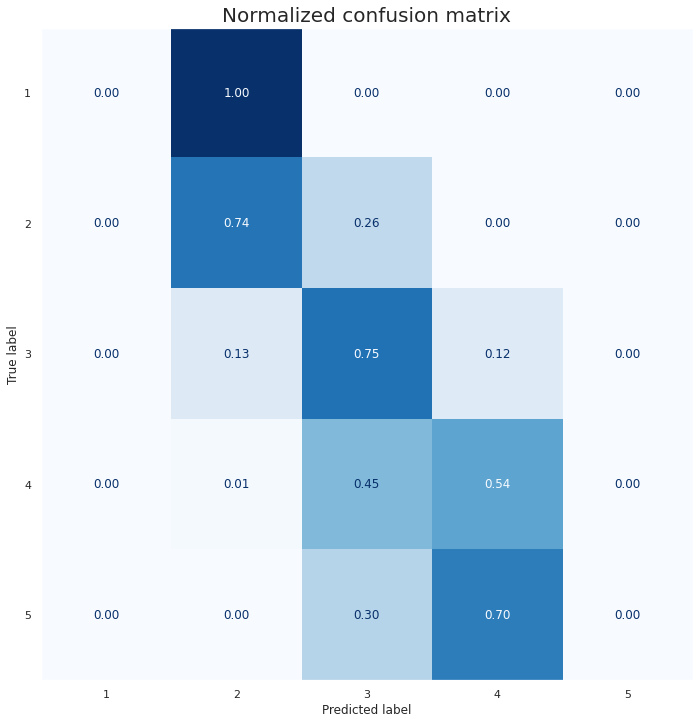

In [ ]:
labels = ['1','2','3','4','5']
predictions = rnn_model.predict(X_test)
y_preds = np.argmax(predictions, axis=1)
y_test = np.argmax(Y_test, axis =1)
plot_confusion_matrix(y_preds, y_test, labels)

We used the Confusion Matrix to visualize how our model performs in classifying our 5 classes.

From the results above we can see that it has some problems with the identification of classes 1 and 5 and in some of the cases also in the identification of class 4, that is confused with class 5.

For the first and last class the sentences are predicted in the adjacent classes since the small number of sentences make difficult for the model to retain the necessary information to predict correctly those classes.


### Changing classes

#### Data Preparation

An idea to increase the performance of the model may be solving the problem of unbalanced classes by grouping them according to what the plots will suggest.

In [ ]:
df_median = pd.DataFrame(sentence)
df_median['Judgement'] = np.array(l_meds)
df_median['Judgement'] = df_median['Judgement'].replace([5, 6], 4) 
newmed_abs_val = df_median['Judgement'].value_counts()
newmed_rel_val = round(df_median['Judgement'].value_counts(normalize = True), 4)

In [ ]:
new_data_med = pd.DataFrame(newmed_rel_val.sort_index())

new_data_med.insert(1, "%", [str(round(t * 100, 4))+'%' for t in new_data_med['Judgement']] , True) #adding the percentage column

To check the distribution of the classes we plot them in the new form

In [ ]:
fig = px.bar(new_data_med, color = [1, 2, 3, 4],
             labels = {
                 'index' : 'Judgement', 'value': 'Percentage (%)'
                 },
             title = 'Complexity Judgement for Median', 
             text = '%'
             )
fig.update(layout_coloraxis_showscale=False)

fig.update_xaxes(range = [0,5])
fig.show()

Now we do the same procedure for the Mean 

In [ ]:
df_mean = df
df_mean['Judgement'] = df_mean['Judgement'].replace([5, 6], 4)
newmean_abs_val = df_mean['Judgement'].value_counts()
newmean_rel_val = round(df_mean['Judgement'].value_counts(normalize = True), 4)

In [ ]:
new_data_mean = pd.DataFrame(newmean_rel_val.sort_index())

new_data_mean.insert(1, "%", [str(round(t * 100, 4))+'%' for t in new_data_mean['Judgement']] , True) #adding the percentage column

In [ ]:
fig = px.bar(new_data_mean, color = [1, 2, 3, 4],
             labels = {
                 'index' : 'Judgement', 'value': 'Percentage (%)'
                 },
             title = 'Complexity Judgement for Mean', 
             text = '%'
             )
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(range = [0,5])
fig.show()

Since our aim is to avoid or reduce the imbalance of some classes, we decide to use the median as it seems to have sligthly more balanced classes, especially for Judgement: 1

In [ ]:
data = df_median

data['SENTENCE'] = data['SENTENCE'].apply(lambda x: x.lower())
data['Judgement'] = data['Judgement'].apply(lambda x: str(x))

# tokenization of the senteces
max_features = 10000
tokenizer = Tokenizer(num_words = max_features, split=' ')
tokenizer.fit_on_texts(data['SENTENCE'].values)

X = tokenizer.texts_to_sequences(data['SENTENCE'].values)

In [ ]:
sequence_len = np.array([len(s) for s in X])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

# visualizing the percentile of te sentences length
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 39
[('75%', 26.0), ('80%', 28.0), ('85%', 29.0), ('90%', 31.0), ('95%', 32.0), ('100%', 39.0)]


In [ ]:
X = pad_sequences(X)

In [ ]:
Y = pd.get_dummies(data['Judgement']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

#### LSTM model

We applied some models we tried before to the new dataset to performs the Cross Validation.

In [ ]:
embed_dim = 256
lstm_out = 196

batch_size = 128

model_grouped = Sequential()

model_grouped.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
# LSTM
model_grouped.add(LSTM(lstm_out, dropout = 0.2, recurrent_dropout = 0.2))
# linear NN
model_grouped.add(Dense(4, activation = 'softmax'))

K_fold_cross_validation(model_train = model_grouped, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 3s - loss: 1.3629 - accuracy: 0.3389 - 3s/epoch - 556ms/step
Epoch 2/5
6/6 - 1s - loss: 1.1985 - accuracy: 0.4383 - 1s/epoch - 170ms/step
Epoch 3/5
6/6 - 1s - loss: 1.0104 - accuracy: 0.5858 - 1s/epoch - 173ms/step
Epoch 4/5
6/6 - 1s - loss: 0.9192 - accuracy: 0.5919 - 1s/epoch - 174ms/step
Epoch 5/5
6/6 - 1s - loss: 0.8189 - accuracy: 0.6401 - 1s/epoch - 195ms/step
Score for fold 1: loss of 0.8672003746032715; accuracy of 56.62650465965271%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 3s - loss: 1.3631 - accuracy: 0.3328 - 3s/epoch - 580ms/step
Epoch 2/5
6/6 - 1s - loss: 1.2137 - accuracy: 0.4096 - 1s/epoch - 183ms/step
Epoch 3/5
6/6 - 1s - loss: 1.0408 - accuracy: 0.5828 - 1s/epoch - 178ms/step
Epoch 4/5
6/6 - 1s - loss: 0.9158 - accuracy: 0.5843 - 1s/epoch - 183ms/step
Epoch 5/5
6/6 - 1s - loss: 0.7722 - 

With the simplest LSTM model we reach a validation accuracy of around 56%.

As before, we tried to modify the previous model:

* Increase the dropout in the LSTM layer to 50%
* DropOut layer of 50%
* addig another LSTM layer

In [ ]:
embed_dim = 256
lstm_out = 196

model_grouped = Sequential()
model_grouped.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model_grouped.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4, return_sequences = True))
model_grouped.add(Dropout(.5))
model_grouped.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4))
model_grouped.add(Dense(4, activation='softmax'))

K_fold_cross_validation(model_train = model_grouped, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 8s - loss: 1.3514 - accuracy: 0.3389 - 8s/epoch - 1s/step
Epoch 2/5
6/6 - 2s - loss: 1.1559 - accuracy: 0.5211 - 2s/epoch - 357ms/step
Epoch 3/5
6/6 - 2s - loss: 0.9672 - accuracy: 0.5467 - 2s/epoch - 357ms/step
Epoch 4/5
6/6 - 2s - loss: 0.8519 - accuracy: 0.6265 - 2s/epoch - 368ms/step
Epoch 5/5
6/6 - 2s - loss: 0.8054 - accuracy: 0.6581 - 2s/epoch - 357ms/step
Score for fold 1: loss of 0.818335771560669; accuracy of 66.86747074127197%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 7s - loss: 1.3413 - accuracy: 0.3328 - 7s/epoch - 1s/step
Epoch 2/5
6/6 - 2s - loss: 1.1751 - accuracy: 0.4804 - 2s/epoch - 350ms/step
Epoch 3/5
6/6 - 2s - loss: 0.9570 - accuracy: 0.5783 - 2s/epoch - 351ms/step
Epoch 4/5
6/6 - 2s - loss: 0.8314 - accuracy: 0.6521 - 2s/epoch - 362ms/step
Epoch 5/5
6/6 - 2s - loss: 0.7263 - accurac

We see that with this architecture we reach 61% of validation accuracy so we see a slight improvement.

#### Bi-LSTM

Following the same procedure as before we applied the two Bidirectional LSTM layers and the DropOut layer of 50%.

In [ ]:
embed_dim = 256
lstm_out = 196

model_grouped = Sequential()
model_grouped.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model_grouped.add(Bidirectional(LSTM(lstm_out, return_sequences=True, 
                                 dropout = 0.2)))  
model_grouped.add(Dropout(.5))
model_grouped.add(Bidirectional(LSTM(lstm_out, return_sequences=False, 
                                 dropout = 0.2)))
model_grouped.add(Dense(4, activation='softmax'))

K_fold_cross_validation(model_train = model_grouped, X_train = X_train, Y_train = Y_train, no_epochs = 5)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
6/6 - 7s - loss: 1.3180 - accuracy: 0.3358 - 7s/epoch - 1s/step
Epoch 2/5
6/6 - 0s - loss: 1.0509 - accuracy: 0.5316 - 165ms/epoch - 27ms/step
Epoch 3/5
6/6 - 0s - loss: 0.9526 - accuracy: 0.5482 - 162ms/epoch - 27ms/step
Epoch 4/5
6/6 - 0s - loss: 0.7909 - accuracy: 0.6657 - 161ms/epoch - 27ms/step
Epoch 5/5
6/6 - 0s - loss: 0.6705 - accuracy: 0.7259 - 163ms/epoch - 27ms/step
Score for fold 1: loss of 0.868973433971405; accuracy of 62.04819083213806%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
6/6 - 6s - loss: 1.3375 - accuracy: 0.3148 - 6s/epoch - 958ms/step
Epoch 2/5
6/6 - 0s - loss: 1.1097 - accuracy: 0.5060 - 178ms/epoch - 30ms/step
Epoch 3/5
6/6 - 0s - loss: 0.8757 - accuracy: 0.6431 - 161ms/epoch - 27ms/step
Epoch 4/5
6/6 - 0s - loss: 0.6857 - accuracy: 0.7289 - 165ms/epoch - 27ms/step
Epoch 5/5
6/6 - 0s - loss:

We see that with grouped classes we obtain a worse result with Bi-LSTM with respect to the LSTM model.

#### Best model with grouped classes

This time the best model is the LSTM model.

In the following chunk we fit it.

In [ ]:
embed_dim = 256
lstm_out = 196

batch_size = 128


rnn_model_grouped = Sequential()
rnn_model_grouped.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
rnn_model_grouped.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4, return_sequences = True))
rnn_model_grouped.add(Dropout(.5))
rnn_model_grouped.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4))
rnn_model_grouped.add(Dense(4, activation='softmax'))

rnn_model_grouped.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

rnn_model_grouped.fit(X_train, Y_train, epochs = 6,batch_size=batch_size, verbose = 2)

Epoch 1/6
7/7 - 7s - loss: 1.3429 - accuracy: 0.3494 - 7s/epoch - 1s/step
Epoch 2/6
7/7 - 2s - loss: 1.1066 - accuracy: 0.5578 - 2s/epoch - 344ms/step
Epoch 3/6
7/7 - 2s - loss: 0.9069 - accuracy: 0.5976 - 2s/epoch - 349ms/step
Epoch 4/6
7/7 - 3s - loss: 0.8198 - accuracy: 0.6277 - 3s/epoch - 365ms/step
Epoch 5/6
7/7 - 2s - loss: 0.7273 - accuracy: 0.7169 - 2s/epoch - 355ms/step
Epoch 6/6
7/7 - 3s - loss: 0.6034 - accuracy: 0.7711 - 3s/epoch - 360ms/step


Prediction and confusion matrix

In [ ]:
def from_encode_to_literal_labels(y_true, y_pred):
    # Transform sequences of encoded labels in sequences of string labels
    let_y_true = list()
    let_y_pred = list()
    for sent_idx in range(len(y_true)):
        let_y_true.append(str(y_true[sent_idx] + 1))
        let_y_pred.append(str(y_pred[sent_idx] + 1))
    
    return let_y_true, let_y_pred

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test)]

for title, X, Y in datasets:
    Y_pred = rnn_model_grouped.predict(X, batch_size = batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis = -1))
    Y = np.array(np.argmax(Y, axis=-1))
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred)


    print(title)
    print(metrics.classification_report(let_y_true, let_y_pred))
    print('\n')


7/7 [==============================] - 1s 33ms/step
Training Set
              precision    recall  f1-score   support

           1       0.92      0.89      0.90       115
           2       0.82      0.91      0.86       301
           3       0.78      0.76      0.77       229
           4       0.90      0.78      0.84       185

    accuracy                           0.84       830
   macro avg       0.86      0.84      0.84       830
weighted avg       0.84      0.84      0.84       830



3/3 [==============================] - 0s 29ms/step
Test Set
              precision    recall  f1-score   support

           1       0.71      0.63      0.67        46
           2       0.63      0.74      0.68       128
           3       0.51      0.52      0.52       109
           4       0.65      0.48      0.55        73

    accuracy                           0.61       356
   macro avg       0.63      0.59      0.60       356
weighted avg       0.61      0.61      0.60       356





Focusing on the prediction we see:
 
*   Again, the Model tends to overfit the Training Set: this time we decided to stop the training after 6 epochs to try to reduce the overfitting problem;
*   This time the performance of the model is more homogeneous across classes because of the grouping;
*   We notice a better performance in the first two classes meaning that the model is better at predicting easier sentences rather than complex.

12/12 [==============================] - 0s 23ms/step


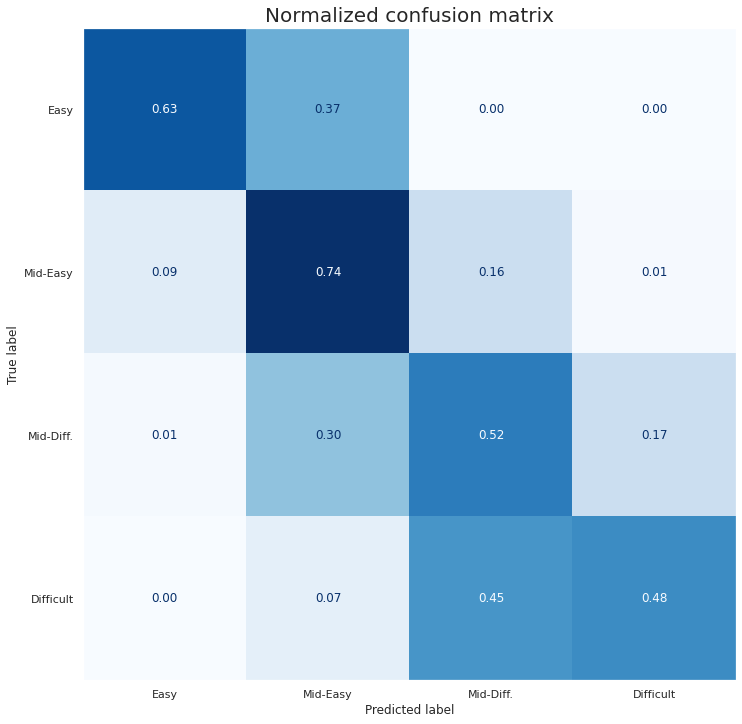

In [ ]:
labels = ['Easy','Mid-Easy','Mid-Diff.','Difficult']
predictions = rnn_model_grouped.predict(X_test)
y_preds = np.argmax(predictions, axis=1)
y_test = np.argmax(Y_test, axis =1)
plot_confusion_matrix(y_preds, y_test, labels)

In the confusion matrix above we see what we described in the previous comment with a difficulty in classifying the "Mid-Diff" and "Difficult" classes.

### Data Augmentation

To solve the overfitting problem, we tried with a DataAugmentation approach using the package 'textattack' and the EasyDataAugmenter function.

In [ ]:
!pip install textattack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 37.6 MB/s 
     |████████████████████████████████| 60 kB 9.0 MB/s 
     |████████████████████████████████| 41.4 MB 1.7 MB/s 
     |████████████████████████████████| 365 kB 68.1 MB/s 
     |████████████████████████████████| 125 kB 45.2 MB/s 
     |████████████████████████████████| 769 kB 63.4 MB/s 
     |████████████████████████████████| 3.6 MB 63.1 MB/s 
     |████████████████████████████████| 401 kB 65.9 MB/s 
     |████████████████████████████████| 5.8 MB 50.1 MB/s 
     |████████████████████████████████| 182 kB 79.6 MB/s 
     |████████████████████████████████| 212 kB 66.9 MB/s 
     |████████████████████████████████| 132 kB 80.7 MB/s 
     |████████████████████████████████| 95 kB 6.2 MB/s 
     |████████████████████████████████| 127 kB 54.2 MB/s 
     |████████████████████████████████| 7.6 MB 64.7 MB/s 
     |█████████████████████████████

#### EasyDataAugmenter

In [ ]:
from textattack.augmentation import EasyDataAugmenter

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


This function performs Data Augmentation with an output of 4 sentences:

* Original sentence
* A random shuffled version of the first one
* the first one with Random inserted words as synonims
* the Sentence with Random deleted words

In [ ]:
# showing an example

text = "I was billed twice for the service and this is the second time it has happened"

eda_aug = EasyDataAugmenter()

eda_aug.augment(text)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


['iodin was billed twice for the service and this is the second time it has happened',
 'I was billed twice bump for the service and this is the second time it has happened',
 'I was billed twice for the service and this is the second time it happened',
 'I was billed twice for the service second this is the and time it has happened']

In [ ]:
cols_names = np.array(['SENTENCE', 'Judgement'])

In [ ]:
data

,SENTENCE,Judgement
0,amcast industrial corp. said it plans to repur...,2
1,gdp is the total value of a nation's output of...,1
2,"town & country ford in charlotte, n.c., still ...",2
3,"a couple in rockford, ill., raised $ 12,591 ea...",3
4,yesterday the company said it had filed a requ...,3
...,...,...
1181,"also as usual, the products will appeal mostly...",2
1182,call money: 9 3/4 % to 10 %.,3
1183,source: fulton prebon (u.s.a.) inc.,2
1184,the record price for a full membership on the ...,2


We decide to apply this augmenter in the dataset by appending the generated sentences (with the same judgement as the sentence they're generated from) at the bottom of the dataset.

In [ ]:
data_augmented = pd.DataFrame(columns = cols_names)

In [ ]:
data_augmented

,SENTENCE,Judgement


In [ ]:
for i in range(data.shape[0]):
  new = eda_aug.augment(data.loc[i,'SENTENCE'])
  if len(new) == 4:
    for j in new:
      new_df = pd.DataFrame() 
      new_judg = data.loc[i,'Judgement']
      new_data = {'SENTENCE': j , 'Judgement': new_judg}
      new_df = new_df.append(new_data, ignore_index=True)
      data_augmented = data_augmented.append(new_df)
      data_augmented.reset_index(drop= True)

In [ ]:
prova = data_augmented.reset_index(drop= True)

In [ ]:
data_augmented = prova

In [ ]:
data_augmented

,SENTENCE,Judgement
0,amcast industrial corp. outstanding it plans t...,2
1,amcast industrial corp. said it plans to repur...,2
2,amcast industrial corp. said it plans to repur...,2
3,amcast industrial corp. said it plans to repur...,2
4,gdp is the total value of a nation's output go...,1
...,...,...
4739,the price for a full membership on the exchang...,2
4740,ual declined to gossip on british air's statem...,2
4741,ual declined to comment on along british air's...,2
4742,ual declined to on british air's statement.,2


In [ ]:
data_augmented['SENTENCE'] = data_augmented['SENTENCE'].apply(lambda x: x.lower())
data_augmented['Judgement'] = data_augmented['Judgement'].apply(lambda x: str(int(x)))

# tokenization of the senteces
max_features = 10000
tokenizer_aug = Tokenizer(num_words = max_features, split=' ')
tokenizer_aug.fit_on_texts(data_augmented['SENTENCE'].values)

X_augmented = tokenizer_aug.texts_to_sequences(data_augmented['SENTENCE'].values)

In [ ]:
sequence_len = np.array([len(s) for s in X_augmented])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

# visualizing the percentile of te sentences length
print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 41
[('75%', 26.0), ('80%', 27.0), ('85%', 29.0), ('90%', 30.0), ('95%', 33.0), ('100%', 41.0)]


In [ ]:
X_augmented = pad_sequences(X_augmented, maxlen = 41)

In [ ]:
Y = pd.get_dummies(data_augmented['Judgement']).values

In [ ]:
np.sum(Y, axis= 0)

array([ 644, 1716, 1352, 1032], dtype=uint64)

Since we want the Train and the Test to remain with both original and synthetic sentences, we first split by Random Sampling from the range of the index of the original sentences dataset length [1; 1186] and then we took the corresponding indexes of the synthetic ones

In [ ]:
np.random.seed(10 + 700)
train_size = 0.7
test_size = 0.3
test_idx = []

idx = np.random.choice(len(X), int(train_size*len(X)), replace = False)
idx = list(idx)

X_train = X[idx,:]
Y_train = Y[idx,:]

aug_idx = []
for i in idx:
  if i == 0:
    g = np.arange(4)
  else:
    g = np.arange(4*i, 4*(i+1) - 1)
  for j in g:
    aug_idx.append(j)

data_augmented = data_augmented.iloc[aug_idx,:]
data_augmented = data_augmented.reset_index(drop = True)

for i in range(X.shape[0]):
  if i not in idx:
    test_idx.append(i)

X_test = X[test_idx,:]
Y_test = Y[test_idx,:]

In [ ]:
X_train = pad_sequences(X_train, 41)

In [ ]:
X_test = pad_sequences(X_test, 41)

##### LSTM model

We decide to apply the best model chosen before to the augmented dataset.

In [ ]:
embed_dim = 128
lstm_out = 196

batch_size = 128

rnn_model_augmented = Sequential()

rnn_model_augmented.add(Embedding(max_features, embed_dim, input_length = X_augmented.shape[1]))
rnn_model_augmented.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4, return_sequences = True))
rnn_model_augmented.add(Dropout(.5))
rnn_model_augmented.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.4))
rnn_model_augmented.add(Dense(4, activation='softmax'))

rnn_model_augmented.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

rnn_model_augmented.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2)
rnn_model_augmented.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Epoch 1/20
2/2 - 8s - loss: 1.3834 - accuracy: 0.2771 - 8s/epoch - 4s/step
Epoch 2/20
2/2 - 1s - loss: 1.3558 - accuracy: 0.3655 - 760ms/epoch - 380ms/step
Epoch 3/20
2/2 - 1s - loss: 1.3016 - accuracy: 0.3655 - 795ms/epoch - 397ms/step
Epoch 4/20
2/2 - 1s - loss: 1.3354 - accuracy: 0.3454 - 713ms/epoch - 357ms/step
Epoch 5/20
2/2 - 1s - loss: 1.3038 - accuracy: 0.4578 - 798ms/epoch - 399ms/step
Epoch 6/20
2/2 - 1s - loss: 1.3147 - accuracy: 0.4859 - 830ms/epoch - 415ms/step
Epoch 7/20
2/2 - 1s - loss: 1.3122 - accuracy: 0.4618 - 724ms/epoch - 362ms/step
Epoch 8/20
2/2 - 1s - loss: 1.2970 - accuracy: 0.4337 - 706ms/epoch - 353ms/step
Epoch 9/20
2/2 - 1s - loss: 1.2713 - accuracy: 0.4699 - 739ms/epoch - 370ms/step
Epoch 10/20
2/2 - 1s - loss: 1.2441 - accuracy: 0.5020 - 720ms/epoch - 360ms/step
Epoch 11/20
2/2 - 1s - loss: 1.2143 - accuracy: 0.5060 - 712ms/epoch - 356ms/step
Epoch 12/20
2/2 - 1s - loss: 1.1685 - accuracy: 0.5341 - 704ms/epoch - 352ms/step
Epoch 13/20
2/2 - 1s - loss: 1.

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test)]

for title, X, Y in datasets:
    Y_pred = rnn_model_augmented.predict(X, batch_size = batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis = -1))
    Y = np.array(np.argmax(Y, axis=-1))
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred)

    print(title)
    print(metrics.classification_report(let_y_true, let_y_pred))
    print('\n')

2/2 [==============================] - 0s 33ms/step
Training Set
              precision    recall  f1-score   support

           1       1.00      0.73      0.84        26
           2       0.97      0.99      0.98        87
           3       0.95      0.99      0.97        79
           4       0.90      0.93      0.91        57

    accuracy                           0.95       249
   macro avg       0.95      0.91      0.93       249
weighted avg       0.95      0.95      0.95       249



1/1 [==============================] - 0s 42ms/step
Test Set
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.44      0.24      0.31        33
           3       0.33      0.52      0.40        29
           4       0.33      0.45      0.38        31

    accuracy                           0.35       107
   macro avg       0.27      0.30      0.27       107
weighted avg       0.32      0.35      0.31       107





The Results by the Fitting of the model on the Augmented Data show that the model is negatively affected by the augmentation.

Despite taking more epochs to fit the training data we see very bad results in the precision and recall metrics for all classes.

4/4 [==============================] - 0s 27ms/step


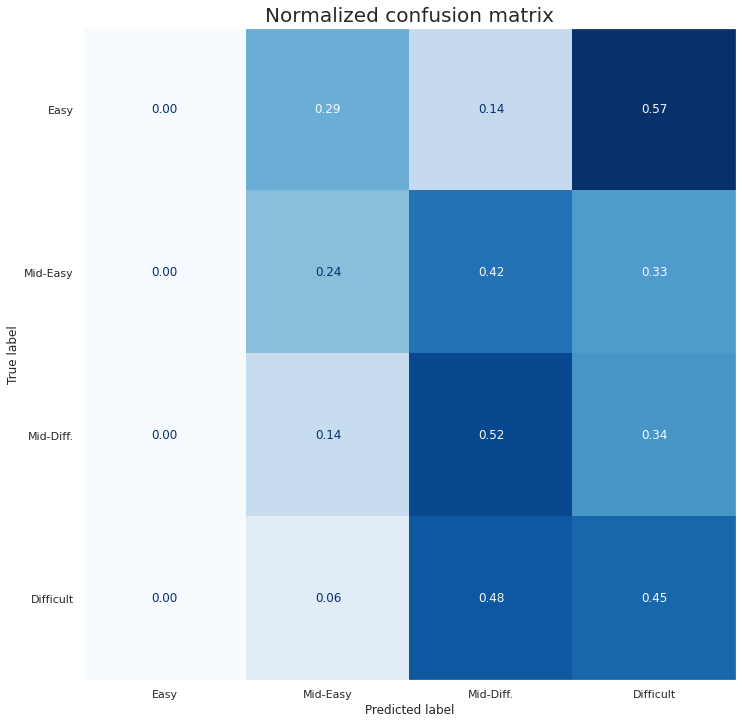

In [ ]:
labels = ['Easy','Mid-Easy','Mid-Diff.','Difficult']
predictions = rnn_model_augmented.predict(X_test)
y_preds = np.argmax(predictions, axis=1)
y_test = np.argmax(Y_test, axis =1)
plot_confusion_matrix(y_preds, y_test, labels)

This problem in the evaluation is showed visually also in the Confusion Matrix, where we can see that for all the classes from 'Easy' to 'Difficult' the model has big problems in correctely predict the labels.

In addition the model tend to predict the sentence as Mid-Diff. or Difficult.

## **TRANSFORMERS**

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from utils_1 import dataio
from utils_1 import dataio, kerasutils, modelutils
!pip install torch
!pip install transformers
!pip install umap-learn
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from tqdm import tqdm
!pip install seqeval
from seqeval.metrics import classification_report
from transformers import AutoTokenizer
!pip install datasets
import datasets
from datasets import DatasetDict, Dataset
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=04c471febe7c96c445bbabd4d51914efb752092efe912337e14dd46f2495065e
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=a2b4b6aca1954bbe4dfc53a86a7fc9f7ecc311dd86a5fc94df93524845a7e6cd
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent
Looking in inde

Now we apply the Transformers tool on the dataset with grouped classes according to the Median as indicator.

In [ ]:
data = df_median
data['SENTENCE'] = data['SENTENCE'].apply(lambda x: x.lower())
data['Judgement'] = data['Judgement'].apply(lambda x: int(str(x))-1)

In [ ]:
sentences = data['SENTENCE']
ex_sent = data['SENTENCE'][0]
ex_sent

'amcast industrial corp. said it plans to repurchase 500,000 shares, or about 7 % of its shares outstanding, in open market transactions.'

### DistilBert

We decide to apply two Models and compare them to evaluate the best one.

First we implement the DistilBert, which is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenized_sentence = tokenizer(ex_sent, padding='max_length', max_length=39,truncation=True, return_tensors="pt")
print(tokenizer.decode(tokenized_sentence.input_ids[0]))

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

[CLS] amcast industrial corp. said it plans to repurchase 500, 000 shares, or about 7 % of its shares outstanding, in open market transactions. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
print(tokenizer.convert_ids_to_tokens(tokenized_sentence["input_ids"][0]))

['[CLS]', 'amc', '##ast', 'industrial', 'corp', '.', 'said', 'it', 'plans', 'to', 'rep', '##ur', '##chase', '500', ',', '000', 'shares', ',', 'or', 'about', '7', '%', 'of', 'its', 'shares', 'outstanding', ',', 'in', 'open', 'market', 'transactions', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Here we perform the data preparation for the model

In [ ]:
X,Y = data['SENTENCE'] , data['Judgement']

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.10, random_state = 42)

In [ ]:
train_ds_pandas = pd.concat([pd.Series(X_train),pd.Series(Y_train)],axis=1)
valid_ds_pandas = pd.concat([pd.Series(X_valid),pd.Series(Y_valid)],axis=1)
test_ds_pandas = pd.concat([pd.Series(X_test),pd.Series(Y_test)],axis=1)

In [ ]:
train_ds_pandas.columns = ['text', 'label']
valid_ds_pandas.columns = ['text', 'label']
test_ds_pandas.columns = ['text', 'label']

In [ ]:
trainds = Dataset.from_pandas(train_ds_pandas)
vds = Dataset.from_pandas(valid_ds_pandas)
testds = Dataset.from_pandas(test_ds_pandas)

In order to deal with the transformer model we decided to create a DatasetDict object and put our data in it.

In [ ]:
ds = DatasetDict()

ds['train'] = trainds
ds['validation'] = vds
ds['test'] = testds

print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 747
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 83
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 356
    })
})


In [ ]:
print(tokenize(ds["train"][:2]))

{'input_ids': [[101, 20230, 5211, 3694, 4546, 3404, 1010, 3731, 1010, 2001, 3205, 2007, 1996, 6454, 18720, 2213, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 21962, 14083, 3919, 13058, 1012, 2056, 2009, 3488, 2000, 16360, 3126, 26300, 3156, 1010, 2199, 6661, 1010, 2030, 2055, 1021, 1003, 1997, 2049, 6661, 5151, 1010, 1999, 2330, 3006, 11817, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In the following chunk we check for the correctness of the tokenization applied in the previous chunk.

In [ ]:
print(ds_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


As said at the beginning of this section we downloaded the distilbert model.

In [ ]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} 

In [ ]:
ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
ds_hidden = ds_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

As done before for the tokenization we looked at the correctness of the extraction of the hidden states.

In [ ]:
ds_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
X_train = np.array(ds_hidden["train"]["hidden_state"])
X_valid = np.array(ds_hidden["validation"]["hidden_state"])
y_train = np.array(ds_hidden["train"]["label"])
y_valid = np.array(ds_hidden["validation"]["label"])
X_test = np.array(ds_hidden["test"]["hidden_state"])
y_test = np.array(ds_hidden["test"]["label"])

X_train.shape, X_valid.shape, X_test.shape

((747, 768), (83, 768), (356, 768))

In [ ]:
import umap.umap_ as umap # the UMAP approach is implement in umap-learn.
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,10.542037,6.137347,1
1,11.575966,6.541819,1
2,11.176594,3.671825,3
3,9.427877,2.450756,1
4,9.392044,8.347905,2


Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

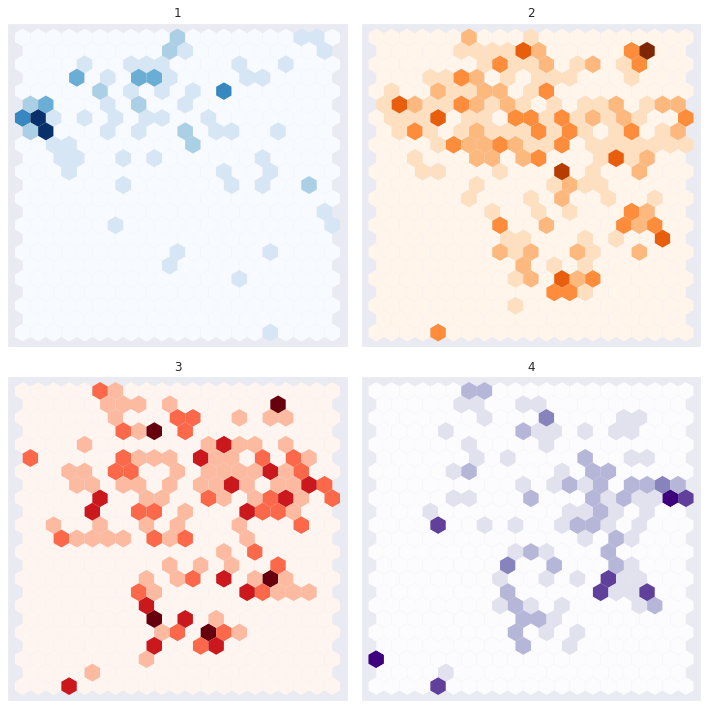

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()
cmaps = ["Blues", "Oranges", "Reds", "Purples"]
labels = ['1','2','3','4']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,)) 
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From the plot above we can see that the second and third classes have very similar patterns and it is reasonable that our models have difficulties in classify correctly these 2 classes.

Now that we've gained some insight into the features of our dataset, let's finally train a model on it.

We try to fit the model with pre-trained weights to see how well it predicts.

In [ ]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_valid, y_valid)

0.5903614457831325

We see an accuracy of 59% on the validation set, which is coherent with the results obtained with the RNN results.

In [ ]:
lr_clf.score(X_test, y_test)

0.550561797752809

A slightly worse result is achieved on the test set

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.2891566265060241

The Dummy classifier represents a sort of lower bound for the accuracy since it predicts without considering informations contained in the features.

We see that our models have an accuracy of over the double of the dummy classifier.

In [ ]:
y_preds = lr_clf.predict(X_test)
y_test = np.array(ds_hidden["test"]["label"])

In [ ]:
let_y_true, let_y_pred = from_encode_to_literal_labels(y_test, y_preds)
print('Test set')
print(metrics.classification_report(let_y_true, let_y_pred))

Test set
              precision    recall  f1-score   support

           1       0.63      0.59      0.61        46
           2       0.60      0.68      0.64       128
           3       0.47      0.41      0.44       109
           4       0.52      0.51      0.51        73

    accuracy                           0.55       356
   macro avg       0.55      0.55      0.55       356
weighted avg       0.55      0.55      0.55       356



In the chunk above we see that for the Test set we still see that the pre-trained Distilbert behaves exactly like the RNN, meaning that the first 2 classes are better predicted than the last 2.

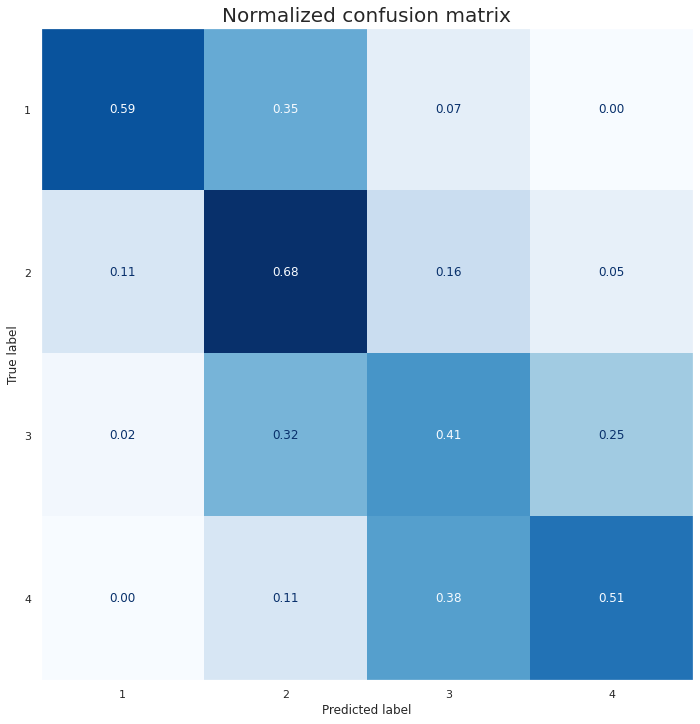

In [ ]:
plot_confusion_matrix(y_preds, y_test, labels)

This confusion matrix restates what we said before looking at the accuracies of each class.

#### Fine Tuning 

After downloading the pretrained DistilBert, we need to do the fine tuning in order to adapt the pre trained weights to our dataset. 


In [ ]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                      
num_labels = 4 
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=4)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

We define the ComputeMetrics( ) function which takes the prediction made by the model and outputs a Dictionary with {**metrics**: *value*} (in this case we use Accuracy and F1-score).

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Then we define the Training parameters with the TrainingArguments( ); this function will store all the information from the training process and will output all of them in the specified *output_dir*

In [ ]:
batch_size = 128
logging_steps = len(ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-judgements"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False, #tqdm to see the progress bar
                                  logging_steps=logging_steps,
                                  push_to_hub=False,  # do not push on the hugging face hub
                                  log_level="error")

Then we use the Trainer to finally tune the model with all the parameters specified before.

In [ ]:
from transformers import Trainer

trainer_distilbert = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"],
                  tokenizer=tokenizer)
trainer_distilbert.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.197700,1.220757,0.361446,0.271734
2,1.127000,1.152886,0.385542,0.310247
3,1.066100,1.064853,0.409639,0.345942
4,0.996700,0.995901,0.493976,0.436707
5,0.867500,0.928605,0.506024,0.459910
6,0.819800,0.907350,0.530120,0.495009
7,0.789400,0.875372,0.554217,0.534924
8,0.754200,0.852550,0.590361,0.574939
9,0.738200,0.848663,0.590361,0.574939
10,0.713300,0.844761,0.590361,0.574939


In [ ]:
preds_output = trainer_distilbert.predict(ds_encoded["test"])
preds_output.metrics

{'test_loss': 0.8787506818771362,
 'test_accuracy': 0.5955056179775281,
 'test_f1': 0.5779441497282515,
 'test_runtime': 0.6685,
 'test_samples_per_second': 532.572,
 'test_steps_per_second': 4.488}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(ds_hidden["test"]["label"])

In [ ]:
let_y_true, let_y_pred = from_encode_to_literal_labels(y_test, y_preds)
print('Test set')
print(metrics.classification_report(let_y_true, let_y_pred))

Test set
              precision    recall  f1-score   support

           1       0.86      0.26      0.40        46
           2       0.60      0.84      0.70       128
           3       0.52      0.50      0.51       109
           4       0.65      0.51      0.57        73

    accuracy                           0.60       356
   macro avg       0.66      0.53      0.55       356
weighted avg       0.62      0.60      0.58       356



After the fine tuning with the DistilBert we see a similar  accuracy to the one obtained without doing the fine tuning.

The precision and recall are quite similar to the one obtained before except for a worse result for the first class.

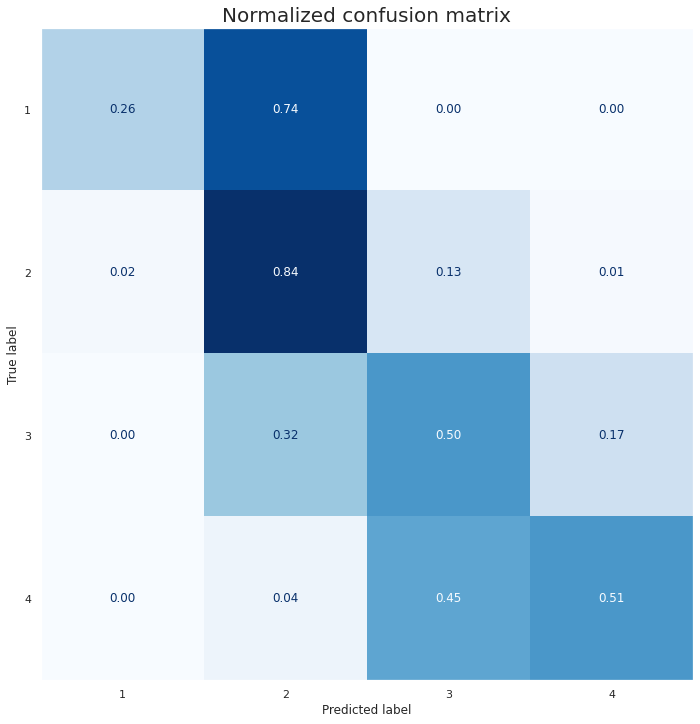

In [ ]:
labels = ['1','2','3','4']
plot_confusion_matrix(y_preds, y_test, labels)

With respect to what we got with the pre-trained Distilbert we can say that we tend to predict more sentences as class '2'.

### Bert

After the DistilBert model we decide to use the BERT Trasformer.

BERT It’s a bidirectional transformer pretrained using language modelling with masking procedure combined with prediction of the next sentence. It is trained on a large corpus of the Toronto Book Corpus and Wikipedia.

In [ ]:
model_ckpt = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                      
num_labels = 4 
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=4)
         .to(device))

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
batch_size = 128
logging_steps = len(ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-judgements"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False, #tqdm to see the progress bar
                                  logging_steps=logging_steps,
                                  push_to_hub=False,  # do not push on the hugging face hub
                                  log_level="error")

#### Fine Tuning

After downloading the pretrained Bert, we need to do the fine tuning in order to adapt the pre trained weights to our dataset. 

In [ ]:
from transformers import Trainer

trainer_bert = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"],
                  tokenizer=tokenizer)
trainer_bert.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.100900,1.249084,0.409639,0.385625
2,1.049500,1.172866,0.506024,0.515124
3,0.994600,1.145765,0.457831,0.432377
4,0.957700,1.070292,0.554217,0.552711
5,0.837000,1.043816,0.578313,0.580530
6,0.803800,0.992307,0.566265,0.570137
7,0.735800,0.985157,0.578313,0.571627
8,0.714500,0.944329,0.602410,0.600596
9,0.692900,0.944328,0.626506,0.621275
10,0.656500,0.947824,0.626506,0.622507


In [ ]:
preds_output = trainer_bert.predict(ds_encoded["test"])
preds_output.metrics

{'test_loss': 1.0165163278579712,
 'test_accuracy': 0.550561797752809,
 'test_f1': 0.5340055952326798,
 'test_runtime': 1.1371,
 'test_samples_per_second': 313.064,
 'test_steps_per_second': 2.638}

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_test = np.array(ds_hidden["test"]["label"])

In [ ]:
let_y_true, let_y_pred = from_encode_to_literal_labels(y_test, y_preds)
print('Test set')
print(metrics.classification_report(let_y_true, let_y_pred))

Test set
              precision    recall  f1-score   support

           1       0.57      0.28      0.38        46
           2       0.52      0.80      0.63       128
           3       0.54      0.47      0.50       109
           4       0.71      0.40      0.51        73

    accuracy                           0.55       356
   macro avg       0.58      0.49      0.50       356
weighted avg       0.57      0.55      0.53       356



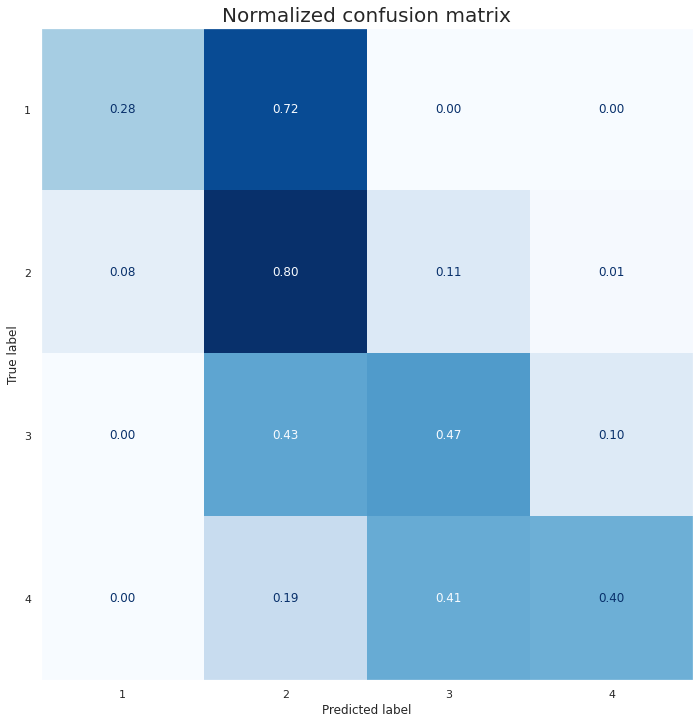

In [ ]:
labels = ['1','2','3','4']
plot_confusion_matrix(y_preds, y_test, labels)

From the classification report and the confusion matrix we see similar results as those obtained with the DistilBert model but with less power to predict the last 2 classes and similar predictive power for the first 2 classes.

# **Conclusion**

To sum up, we reached very similar results both in our best RNN model, DistilBert and Bert transformers.
We claim that the subjectivity that affects the judgements makes the classification task difficult both for a RNN and a pre-trained transformer.